In [ ]:
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input

from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate

from matplotlib import pyplot as plt

170498071/170498071 [==============================] - 11s 0us/step


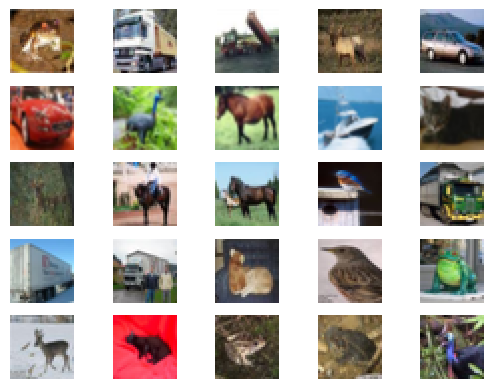

In [ ]:
(trainX, trainy), (testX, testy) = load_data()
# plot 25 images
for i in range(25):
	plt.subplot(5, 5, 1 + i)
	plt.axis('off')
	plt.imshow(trainX[i])
plt.show()


In [ ]:
def define_discriminator(in_shape=(32,32,3), n_classes=10):

    # label input
	in_label = Input(shape=(1,))  #Shape 1
	# embedding for categorical input
    #each label (total 10 classes for cifar), will be represented by a vector of size 50.
    #This vector of size 50 will be learnt by the discriminator
	li = Embedding(n_classes, 50)(in_label) #Shape 1,50
	# scale up to image dimensions with linear activation
	n_nodes = in_shape[0] * in_shape[1]  #32x32 = 1024.
	li = Dense(n_nodes)(li)  #Shape = 1, 1024
	# reshape to additional channel
	li = Reshape((in_shape[0], in_shape[1], 1))(li)  #32x32x1


	# image input
	in_image = Input(shape=in_shape) #32x32x3
	# concat label as a channel
	merge = Concatenate()([in_image, li]) #32x32x4 (4 channels, 3 for image and the other for labels)

	# downsample: This part is same as unconditional GAN upto the output layer.
    #We will combine input label with input image and supply as inputs to the model.
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge) #16x16x128
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe) #8x8x128
	fe = LeakyReLU(alpha=0.2)(fe)
	# flatten feature maps
	fe = Flatten()(fe)  #8192  (8*8*128=8192)
	# dropout
	fe = Dropout(0.4)(fe)
	# output
	out_layer = Dense(1, activation='sigmoid')(fe)  #Shape=1

	# define model
    ##Combine input label with input image and supply as inputs to the model.
	model = Model([in_image, in_label], out_layer)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

test_discr = define_discriminator()
print(test_discr.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 50)        500         ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 1, 1024)      52224       ['embedding[0][0]']              
                                                                                                  
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                              

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:

def define_generator(latent_dim, n_classes=10):

	# label input
	in_label = Input(shape=(1,))  #Input of dimension 1
	# embedding for categorical input
    #each label (total 10 classes for cifar), will be represented by a vector of size 50.
	li = Embedding(n_classes, 50)(in_label) #Shape 1,50

	# linear multiplication
	n_nodes = 8 * 8  # To match the dimensions for concatenation later in this step.
	li = Dense(n_nodes)(li) #1,64
	# reshape to additional channel
	li = Reshape((8, 8, 1))(li)


	# image generator input
	in_lat = Input(shape=(latent_dim,))  #Input of dimension 100

	# foundation for 8x8 image
    # We will reshape input latent vector into 8x8 image as a starting point.
    #So n_nodes for the Dense layer can be 128x8x8 so when we reshape the output
    #it would be 8x8x128 and that can be slowly upscaled to 32x32 image for output.
    #Note that this part is same as unconditional GAN until the output layer.
    #While defining model inputs we will combine input label and the latent input.
	n_nodes = 128 * 8 * 8
	gen = Dense(n_nodes)(in_lat)  #shape=8192
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((8, 8, 128))(gen) #Shape=8x8x128
	# merge image gen and label input
	merge = Concatenate()([gen, li])  #Shape=8x8x129 (Extra channel corresponds to the label)
	# upsample to 16x16
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge) #16x16x128
	gen = LeakyReLU(alpha=0.2)(gen)
	# upsample to 32x32
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen) #32x32x128
	gen = LeakyReLU(alpha=0.2)(gen)
	# output
	out_layer = Conv2D(3, (8,8), activation='tanh', padding='same')(gen) #32x32x3
	# define model
	model = Model([in_lat, in_label], out_layer)
	return model   #Model not compiled as it is not directly trained like the discriminator.

test_gen = define_generator(100, n_classes=10)
print(test_gen.summary())


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 8192)         827392      ['input_4[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 50)        500         ['input_3[0][0]']                
                                                                                            

In [ ]:
def define_gan(g_model, d_model):
	d_model.trainable = False  #Discriminator is trained separately. So set to not trainable.

    ## connect generator and discriminator...
	# first, get noise and label inputs from generator model
	gen_noise, gen_label = g_model.input  #Latent vector size and label size
	# get image output from the generator model
	gen_output = g_model.output  #32x32x3

	# generator image output and corresponding input label are inputs to discriminator
	gan_output = d_model([gen_output, gen_label])
	# define gan model as taking noise and label and outputting a classification
	model = Model([gen_noise, gen_label], gan_output)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model


In [ ]:

# load cifar images
def load_real_samples():
	# load dataset
	(trainX, trainy), (_, _) = load_data()   #cifar
	# convert to floats and scale
	X = trainX.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5   #Generator uses tanh activation so rescale
                            #original images to -1 to 1 to match the output of generator.
	return [X, trainy]

In [ ]:
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

In [ ]:
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = zeros((n_samples, 1))  #Label=0 indicating they are fake
	return [images, labels_input], y

In [ ]:
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels and assign to y (don't confuse this with the above labels that correspond to cifar labels)
	y = np.ones((n_samples, 1))  #Label=1 indicating they are real
	return [X, labels], y


In [ ]:
from PIL import Image

def generate_and_save_images(g_model, latent_dim, label, save_counter):
    n_samples = 64
    [z_input, labels_input] = generate_latent_points(latent_dim, n_samples)
    #labels_input[0] = label
    X = g_model.predict([z_input, labels_input])
    X = (X + 1) / 2.0  # Scale the pixel values from [-1, 1] to [0, 1]

    # for i in range(n_samples):
    #   img = Image.fromarray((X[i] * 255).astype(np.uint8))
    #   filename = '/content/drive/MyDrive/cifar10_generated_images/generated_image_epoch%d_sample%d_label%d.png' % (save_counter, i+1, labels_input[i])
    #   img.save(filename)

In [ ]:
##Berechnung FID

from __future__ import absolute_import, division, print_function
import numpy as np
import os
import gzip, pickle
import tensorflow as tf
from imageio import imread
from scipy import linalg
import pathlib
import urllib
import warnings

class InvalidFIDException(Exception):
    pass


def create_inception_graph(pth):
    """Creates a graph from saved GraphDef file."""
    # Creates graph from saved graph_def.pb.
    with tf.io.gfile.GFile( pth, 'rb') as f:
        graph_def = tf.compat.v1.GraphDef()
        graph_def.ParseFromString( f.read())
        _ = tf.import_graph_def( graph_def, name='')
#-------------------------------------------------------------------------------


# code for handling inception net derived from
#   https://github.com/openai/improved-gan/blob/master/inception_score/model.py
def _get_inception_layer(sess):
    """Prepares inception net for batched usage and returns pool_3 layer. """
    layername = 'pool_3:0'
    pool3 = sess.graph.get_tensor_by_name(layername)
    ops = pool3.graph.get_operations()
    for op_idx, op in enumerate(ops):
        for o in op.outputs:
            shape = o.get_shape()
            if shape._dims is not None:
              #shape = [s.value for s in shape] TF 1.x
              shape = [s for s in shape] #TF 2.x
              new_shape = []
              for j, s in enumerate(shape):
                if s == 1 and j == 0:
                  new_shape.append(None)
                else:
                  new_shape.append(s)
              o.__dict__['_shape_val'] = tf.TensorShape(new_shape)
    return pool3
#-------------------------------------------------------------------------------


def get_activations(images, sess, batch_size=50, verbose=False):
    """Calculates the activations of the pool_3 layer for all images.

    Params:
    -- images      : Numpy array of dimension (n_images, hi, wi, 3). The values
                     must lie between 0 and 256.
    -- sess        : current session
    -- batch_size  : the images numpy array is split into batches with batch size
                     batch_size. A reasonable batch size depends on the disposable hardware.
    -- verbose    : If set to True and parameter out_step is given, the number of calculated
                     batches is reported.
    Returns:
    -- A numpy array of dimension (num images, 2048) that contains the
       activations of the given tensor when feeding inception with the query tensor.
    """
    inception_layer = _get_inception_layer(sess)
    n_images = images.shape[0]
    if batch_size > n_images:
        print("warning: batch size is bigger than the data size. setting batch size to data size")
        batch_size = n_images
    n_batches = n_images//batch_size # drops the last batch if < batch_size
    pred_arr = np.empty((n_batches * batch_size,2048))
    for i in range(n_batches):
        if verbose:
            print("\rPropagating batch %d/%d" % (i+1, n_batches), end="", flush=True)
        start = i*batch_size

        if start+batch_size < n_images:
            end = start+batch_size
        else:
            end = n_images

        batch = images[start:end]
        pred = sess.run(inception_layer, {'ExpandDims:0': batch})
        pred_arr[start:end] = pred.reshape(batch.shape[0],-1)
    if verbose:
        print(" done")
    return pred_arr
#-------------------------------------------------------------------------------


def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).

    Stable version by Dougal J. Sutherland.

    Params:
    -- mu1 : Numpy array containing the activations of the pool_3 layer of the
             inception net ( like returned by the function 'get_predictions')
             for generated samples.
    -- mu2   : The sample mean over activations of the pool_3 layer, precalcualted
               on an representive data set.
    -- sigma1: The covariance matrix over activations of the pool_3 layer for
               generated samples.
    -- sigma2: The covariance matrix over activations of the pool_3 layer,
               precalcualted on an representive data set.

    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, "Training and test mean vectors have different lengths"
    assert sigma1.shape == sigma2.shape, "Training and test covariances have different dimensions"

    diff = mu1 - mu2

    # product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = "fid calculation produces singular product; adding %s to diagonal of cov estimates" % eps
        warnings.warn(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError("Imaginary component {}".format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean
#-------------------------------------------------------------------------------


def calculate_activation_statistics(images, sess, batch_size=10, verbose=False):
    """Calculation of the statistics used by the FID.
    Params:
    -- images      : Numpy array of dimension (n_images, hi, wi, 3). The values
                     must lie between 0 and 255.
    -- sess        : current session
    -- batch_size  : the images numpy array is split into batches with batch size
                     batch_size. A reasonable batch size depends on the available hardware.
    -- verbose     : If set to True and parameter out_step is given, the number of calculated
                     batches is reported.
    Returns:
    -- mu    : The mean over samples of the activations of the pool_3 layer of
               the incption model.
    -- sigma : The covariance matrix of the activations of the pool_3 layer of
               the incption model.
    """
    act = get_activations(images, sess, batch_size, verbose)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma


#------------------
# The following methods are implemented to obtain a batched version of the activations.
# This has the advantage to reduce memory requirements, at the cost of slightly reduced efficiency.
# - Pyrestone
#------------------


def load_image_batch(files):
    """Convenience method for batch-loading images
    Params:
    -- files    : list of paths to image files. Images need to have same dimensions for all files.
    Returns:
    -- A numpy array of dimensions (num_images,hi, wi, 3) representing the image pixel values.
    """
    return np.array([imread(str(fn)).astype(np.float32) for fn in files])

def get_activations_from_files(files, sess, batch_size=50, verbose=False):
    """Calculates the activations of the pool_3 layer for all images.

    Params:
    -- files      : list of paths to image files. Images need to have same dimensions for all files.
    -- sess        : current session
    -- batch_size  : the images numpy array is split into batches with batch size
                     batch_size. A reasonable batch size depends on the disposable hardware.
    -- verbose    : If set to True and parameter out_step is given, the number of calculated
                     batches is reported.
    Returns:
    -- A numpy array of dimension (num images, 2048) that contains the
       activations of the given tensor when feeding inception with the query tensor.
    """
    inception_layer = _get_inception_layer(sess)
    n_imgs = len(files)
    if batch_size > n_imgs:
        print("warning: batch size is bigger than the data size. setting batch size to data size")
        batch_size = n_imgs
    n_batches = n_imgs//batch_size + 1
    pred_arr = np.empty((n_imgs,2048))
    for i in range(n_batches):
        if verbose:
            print("\rPropagating batch %d/%d" % (i+1, n_batches), end="", flush=True)
        start = i*batch_size
        if start+batch_size < n_imgs:
            end = start+batch_size
        else:
            end = n_imgs

        batch = load_image_batch(files[start:end])
        pred = sess.run(inception_layer, {'FID_Inception_Net/ExpandDims:0': batch})
        pred_arr[start:end] = pred.reshape(batch_size,-1)
        del batch #clean up memory
    if verbose:
        print(" done")
    return pred_arr

def calculate_activation_statistics_from_files(files, sess, batch_size=32, verbose=False):
    """Calculation of the statistics used by the FID.
    Params:
    -- files      : list of paths to image files. Images need to have same dimensions for all files.
    -- sess        : current session
    -- batch_size  : the images numpy array is split into batches with batch size
                     batch_size. A reasonable batch size depends on the available hardware.
    -- verbose     : If set to True and parameter out_step is given, the number of calculated
                     batches is reported.
    Returns:
    -- mu    : The mean over samples of the activations of the pool_3 layer of
               the incption model.
    -- sigma : The covariance matrix of the activations of the pool_3 layer of
               the incption model.
    """
    act = get_activations_from_files(files, sess, batch_size, verbose)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

#-------------------------------------------------------------------------------


#-------------------------------------------------------------------------------
# The following functions aren't needed for calculating the FID
# they're just here to make this module work as a stand-alone script
# for calculating FID scores
#-------------------------------------------------------------------------------
def check_or_download_inception(inception_path):
    ''' Checks if the path to the inception file is valid, or downloads
        the file if it is not present. '''
    INCEPTION_URL = 'http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz'
    if inception_path is None:
        inception_path = '/tmp'
    inception_path = pathlib.Path(inception_path)
    model_file = inception_path / 'classify_image_graph_def.pb'
    if not model_file.exists():
        print("Downloading Inception model")
        from urllib import request
        import tarfile
        fn, _ = request.urlretrieve(INCEPTION_URL)
        with tarfile.open(fn, mode='r') as f:
            f.extract('classify_image_graph_def.pb', str(model_file.parent))
    return str(model_file)


def _handle_path(path, sess, low_profile=False):
    if path.endswith('.npz'):
        f = np.load(path)
        m, s = f['mu'][:], f['sigma'][:]
        f.close()
    else:
        path = pathlib.Path(path)
        files = list(path.glob('*.jpg')) + list(path.glob('*.png'))
        if low_profile:
            m, s = calculate_activation_statistics_from_files(files, sess)
        else:
            x = np.array([imread(str(fn)).astype(np.float32) for fn in files])
            m, s = calculate_activation_statistics(x, sess)
            del x #clean up memory
    return m, s


def calculate_fid_given_paths(paths, inception_path, low_profile=False):
    ''' Calculates the FID of two paths. '''
    inception_path = check_or_download_inception(inception_path)

    for p in paths:
        if not os.path.exists(p):
            raise RuntimeError("Invalid path: %s" % p)

    create_inception_graph(str(inception_path))
    with tf.compat.v1.Session() as sess:
        sess.run(tf.compat.v1.global_variables_initializer())
        m1, s1 = _handle_path(paths[0], sess, low_profile=low_profile)
        m2, s2 = _handle_path(paths[1], sess, low_profile=low_profile)
        fid_value = calculate_frechet_distance(m1, s1, m2, s2)
        return fid_value

In [ ]:
##Code generieren
import os
from PIL import Image
import numpy as np
from keras.models import load_model


def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs, n_batch, save_interval=1):
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    save_counter = 0

    # Lists to store generator and discriminator losses
    g_losses = []
    d_losses_real = []
    d_losses_fake = []

    # Manually enumerate epochs
    for i in range(n_epochs):
        # Enumerate batches over the training set
        for j in range(bat_per_epo):

            # Train the discriminator on real and fake images separately (half batch each)
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            d_loss_real, _ = d_model.train_on_batch([X_real, labels_real], y_real)

            [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            d_loss_fake, _ = d_model.train_on_batch([X_fake, labels], y_fake)

            [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
            y_gan = ones((n_batch, 1))
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)

            # Print losses on this batch
            print('Epoch>%d, Batch%d/%d, d1=%.3f, d2=%.3f, g=%.3f' %
                  (i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))

            # Store losses
            d_losses_real.append(d_loss_real)
            d_losses_fake.append(d_loss_fake)
            g_losses.append(g_loss)

        # Save generator images every save_interval epochs
        if (i+1) % save_interval == 0:
            save_counter += 1
            generate_and_save_images(g_model, latent_dim, labels_input[0], save_counter)

            if save_counter % 5 == 0:
                save_model_directory = "models"
                if not os.path.exists(save_model_directory):
                    os.makedirs(save_model_directory)
                g_model.save(os.path.join(save_model_directory, f"/content/drive/MyDrive/generierte_cifar10/model/generator_model_{save_counter+50}.h5"))


    # Save the final generator model
    #g_model.save(f'/content/drive/MyDrive/generierte_cifar10/model/cifar_conditional_generator{n_epochs}+{n_batch}.h5')

    # Plot generator and discriminator losses
    plot_losses(g_losses, d_losses_real, d_losses_fake,)

def plot_losses(g_losses, d_losses_real, d_losses_fake,):
    epochs = range(1, len(g_losses) + 1)

    plt.plot(epochs, g_losses, label='Generator Loss')
    plt.plot(epochs, d_losses_real, label='Discriminator Loss (Real)')
    plt.plot(epochs, d_losses_fake, label='Discriminator Loss (Fake)')

    plt.title('GAN Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    if save_path is not None:
        plt.savefig(save_path)  # Save the plot as an image file
        plt.show()
    else:
        plt.show()  # Display the plot

def plot_losses(g_losses, d_losses_real, d_losses_fake):
    epochs = range(1, len(g_losses) + 1)

    plt.plot(epochs, g_losses, label='Generator Loss')
    plt.plot(epochs, d_losses_real, label='Discriminator Loss (Real)')
    plt.plot(epochs, d_losses_fake, label='Discriminator Loss (Fake)')

    plt.title('GAN Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
def generate_images_from_model(model_path, output_folder, latent_dim, n_samples=500):


    # Laden Sie das Modell
    model = load_model(model_path)

    # Generieren und speichern Sie zufällige Bilder
    # Generieren Sie zufällige latente Punkte und Labels
    latent_points, labels = generate_latent_points(latent_dim, n_samples)

    # Generieren Sie Bilder
    X = model.predict([latent_points, labels])

    # Skalieren Sie von [-1,1] auf [0,1]
    X = (X + 1) / 2.0
    X = (X * 255).astype(np.uint8)

    # # Speichern Sie die zufälligen Bilder
    # for i in range(n_samples):
    #     image = Image.fromarray(X[i])
    #     image.save(os.path.join(output_folder, f'/content/drive/MyDrive/generierte_cifar10/image_{i}.png'))


def calculate_fid(real_images_path, generated_images_path):
    paths = [real_images_path, generated_images_path]
    fid_value = calculate_fid_given_paths(paths, None, low_profile=False)
    print("FID:", fid_value)
    return fid_value


In [ ]:
#Train the GAN

# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
# Load the pre-trained generator model
pretrained_generator = load_model('/content/drive/MyDrive/generierte_cifar10/model/generator_model_50.h5')

# Continue training the pre-trained model
train(pretrained_generator, d_model, gan_model, dataset, latent_dim, n_epochs=50, n_batch=32, save_interval=1)




1/1 [==============================] - 0s 373ms/step


KeyboardInterrupt: ignored

In [ ]:
# Bilder generieren
import os
import os
from PIL import Image
import numpy as np
from keras.models import load_model
model_directory = "/content/drive/MyDrive/generierte_cifar10/model"
model_files = os.listdir(model_directory)
latent_dim = 100
n_samples = 500

for model_file in model_files:
    # Load the model
    model_path = os.path.join(model_directory, model_file)
    model = load_model(model_path)

    # Generate random latent points and labels
    latent_points, labels = generate_latent_points(latent_dim, n_samples)

    # Generate images
    X = model.predict([latent_points, labels])

    # Scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    X = (X * 255).astype(np.uint8)

    # Save the generated images
    output_folder = f"/content/drive/MyDrive/generierte_cifar10/generated_images/{model_file}/"
    os.makedirs(output_folder, exist_ok=True)

    for i in range(n_samples):
        image = Image.fromarray(X[i])
        image.save(os.path.join(output_folder, f"/content/drive/MyDrive/generierte_cifar10/generated_images/{model_file}/image_{i}.png"))
generate_images_from_model(model_path, output_folder, latent_dim, n_samples)


16/16 [==============================] - 0s 18ms/step


16/16 [==============================] - 0s 7ms/step


16/16 [==============================] - 0s 7ms/step


16/16 [==============================] - 0s 7ms/step


16/16 [==============================] - 0s 7ms/step


16/16 [==============================] - 0s 7ms/step


16/16 [==============================] - 0s 7ms/step


16/16 [==============================] - 0s 7ms/step


16/16 [==============================] - 0s 7ms/step


16/16 [==============================] - 0s 7ms/step


OSError: ignored

<ipython-input-12-b1efd01ddc72>:281: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = np.array([imread(str(fn)).astype(np.float32) for fn in files])


FID: 166.68768635519663
FID: 149.95392881894085
FID: 137.43753508982377
FID: 143.69189814823864
FID: 135.65501783465083
FID: 136.5075269729207
FID: 136.08388489398288
FID: 134.03155057860818
FID: 136.2613924732683
FID: 135.7834840619895


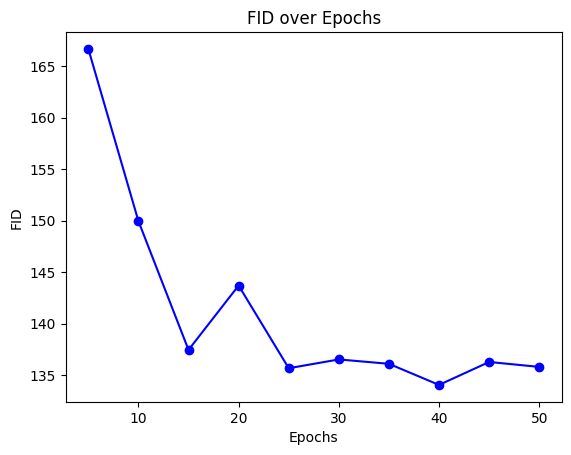

In [ ]:
#FID
import os
import matplotlib.pyplot as plt
import re
real_images_path = '/content/drive/MyDrive/cifar10'
generated_images_path = '/content/drive/MyDrive/generierte_cifar10/generated_images'
subdirectories = [os.path.join(generated_images_path, subdir) for subdir in os.listdir(generated_images_path) if os.path.isdir(os.path.join(generated_images_path, subdir))]
save_path = "/content/drive/MyDrive/generierte_cifar10/model/FID_over_Epochs.png"
# Calculate FID and plot for each subdirectory
epochs = []
fid_values = []

for subdir in subdirectories:
    match = re.search(r'generator_model_(\d+)\.h5', subdir)
    if match:
        epoch = int(match.group(1))
        fid = calculate_fid(real_images_path, subdir)

        epochs.append(epoch)
        fid_values.append(fid)

# Plot FID over epochs
plt.plot(epochs, fid_values, 'bo-')
plt.xlabel('Epochs')
plt.ylabel('FID')
plt.title('FID over Epochs')
plt.savefig(save_path)
plt.show()


In [ ]:
# #auskommentieren
# import matplotlib.pyplot as plt
# import numpy as np
# import keras

# def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs, n_batch, save_interval=1):
#     bat_per_epo = int(dataset[0].shape[0] / n_batch)
#     half_batch = int(n_batch / 2)
#     save_counter = 0

#     # Lists to store generator and discriminator losses
#     g_losses = []
#     d_losses_real = []
#     d_losses_fake = []

#     # Manually enumerate epochs
#     for i in range(n_epochs):
#         # Enumerate batches over the training set
#         for j in range(bat_per_epo):

#             # Train the discriminator on real and fake images separately (half batch each)
#             [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
#             d_loss_real, _ = d_model.train_on_batch([X_real, labels_real], y_real)

#             [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
#             d_loss_fake, _ = d_model.train_on_batch([X_fake, labels], y_fake)

#             [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
#             y_gan = ones((n_batch, 1))
#             g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)

#             # Print losses on this batch
#             print('Epoch>%d, Batch%d/%d, d1=%.3f, d2=%.3f, g=%.3f' %
#                   (i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))

#             # Store losses
#             d_losses_real.append(d_loss_real)
#             d_losses_fake.append(d_loss_fake)
#             g_losses.append(g_loss)

#         # Save generator images every save_interval epochs
#         if (i+1) % save_interval == 0:
#           save_counter += 1
#           generate_and_save_images(g_model, latent_dim,labels_input[0], save_counter)

#     # Save the final generator model
#     g_model.save('cifar_conditional_generator.h5')

#     # Plot generator and discriminator losses
#     plot_losses(g_losses, d_losses_real, d_losses_fake)

# def plot_losses(g_losses, d_losses_real, d_losses_fake):
#     epochs = range(1, len(g_losses) + 1)

#     plt.plot(epochs, g_losses, label='Generator Loss')
#     plt.plot(epochs, d_losses_real, label='Discriminator Loss (Real)')
#     plt.plot(epochs, d_losses_fake, label='Discriminator Loss (Fake)')

#     plt.title('GAN Training Loss')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend()
#     plt.show()


# 新段落

In [ ]:
# #auskommentieren
# def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=20, n_batch=128):
# 	bat_per_epo = int(dataset[0].shape[0] / n_batch)
# 	half_batch = int(n_batch / 2)  #the discriminator model is updated for a half batch of real samples
#                             #and a half batch of fake samples, combined a single batch.
# 	# manually enumerate epochs
# 	for i in range(n_epochs):
# 		# enumerate batches over the training set
# 		for j in range(bat_per_epo):

#              # Train the discriminator on real and fake images, separately (half batch each)
#         #Research showed that separate training is more effective.
# 			# get randomly selected 'real' samples
#             # get randomly selected 'real' samples
# 			[X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)

#             # update discriminator model weights
#             ##train_on_batch allows you to update weights based on a collection
#             #of samples you provide
# 			d_loss_real, _ = d_model.train_on_batch([X_real, labels_real], y_real)

# 			# generate 'fake' examples
# 			[X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
# 			# update discriminator model weights
# 			d_loss_fake, _ = d_model.train_on_batch([X_fake, labels], y_fake)

#             #d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) #Average loss if you want to report single..

# 			# prepare points in latent space as input for the generator
# 			[z_input, labels_input] = generate_latent_points(latent_dim, n_batch)

#             # The generator wants the discriminator to label the generated samples
#         # as valid (ones)
#         #This is where the generator is trying to trick discriminator into believing
#         #the generated image is true (hence value of 1 for y)
# 			# create inverted labels for the fake samples
# 			y_gan = ones((n_batch, 1))
#              # Generator is part of combined model where it got directly linked with the discriminator
#         # Train the generator with latent_dim as x and 1 as y.
#         # Again, 1 as the output as it is adversarial and if generator did a great
#         #job of folling the discriminator then the output would be 1 (true)
# 			# update the generator via the discriminator's error
# 			g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
# 			# Print losses on this batch
# 			print('Epoch>%d, Batch%d/%d, d1=%.3f, d2=%.3f g=%.3f' %
# 				(i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))
# 	# save the generator model
# 	g_model.save('cifar_conditional_generator_64-256epochs.h5')


In [ ]:
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
import numpy as np
#


4/4 [==============================] - 0s 7ms/step


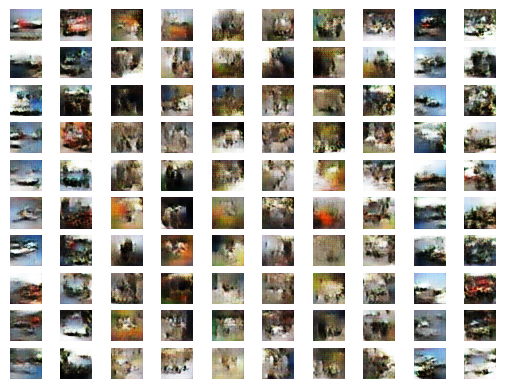

In [ ]:

# load model
model = load_model('/content/drive/MyDrive/generierte_cifar10/model/generator_model_5.h5')

# generate multiple images

latent_points, labels = generate_latent_points(100, 100)
# specify labels - generate 10 sets of labels each gping from 0 to 9
labels = asarray([x for _ in range(10) for x in range(10)])
# generate images
X  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
X = (X*255).astype(np.uint8)
# plot the result (10 sets of images, all images in a column should be of same class in the plot)
# Plot generated images
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, :])
	plt.show()

show_plot(X, 10)

In [ ]:
from PIL import Image
import numpy as np

# Load the model
model = load_model('/content/drive/MyDrive/generierte_cifar10/model/generator_model_40.h5')

# Generate and save random images
latent_dim = 100
n_samples = 1000

# Generate random latent points and labels
latent_points, labels = generate_latent_points(latent_dim, n_samples)

# Generate images
X = model.predict([latent_points, labels])

# Scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
X = (X * 255).astype(np.uint8)

# Save the random images
for i in range(n_samples):
    image = Image.fromarray(X[i])
    image.save(f'/content/drive/MyDrive/generierte_cifar10/generated_images/generator_model_40.h5/image_{i}.png')


16/16 [==============================] - 0s 7ms/step


In [ ]:
real_images_path = "/content/drive/MyDrive/colab/cifar10"
generated_images_path = "/content/drive/MyDrive/colab/cifar10"
paths = [real_images_path, generated_images_path]

fid_value = calculate_fid_given_paths(paths, None, low_profile=False)
print("FID: ", fid_value)

RuntimeError: ignored

In [ ]:
#save with labels
from PIL import Image
import numpy as np

# Load the model
model = load_model('/content/drive/MyDrive/generierte_cifar10/model/generator_model_75.h5')

# Generate and save random images
latent_dim = 100
n_samples = 2000

# Generate random latent points
latent_points = np.random.normal(0, 1, (n_samples, latent_dim))

# Generate random labels
labels = np.random.randint(0, 10, n_samples)

# Generate images
X = model.predict([latent_points, labels])

# Scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
X = (X * 255).astype(np.uint8)

# Save the random images with labels
for i in range(n_samples):
    image = Image.fromarray(X[i])
    image.save(f'/content/drive/MyDrive/generierte_cifar10/gans/generator_model_75.h5/image_{i}_label_{labels[i]}.png')

63/63 [==============================] - 10s 6ms/step


In [ ]:
import os
import imageio
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Ordnerpfad mit den Modellen
model_folder = '/content/drive/MyDrive/generierte_cifar10/model/'

# Ordnerpfad für die generierten Bilder
output_folder = '/content/drive/MyDrive/generierte_cifar10/generated_images/'

# Funktion zum Generieren der latenten Punkte
def generate_latent_points(latent_dim, n_samples):
    latent_points = np.random.normal(0, 1, (n_samples, latent_dim))
    return latent_points

# Funktion zum Skalieren der Bilder
def scale_images(images):
    scaled_images = (images + 1) / 2.0
    scaled_images = (scaled_images * 255).astype(np.uint8)
    return scaled_images

# Funktion zum Erzeugen der GIF-Datei
def generate_gif(images, output_path):
    imageio.mimsave(output_path, images, duration=0.2)

# Durchsuchen aller Modelle im Ordner
for model_file in os.listdir(model_folder):
    if model_file.endswith(".h5"):
        # Liste für generierte Bilder
        generated_images = []

        # Laden des aktuellen Modells
        model_path = os.path.join(model_folder, model_file)
        model = load_model(model_path)

        # Generieren von Bildern mit zufälligen latenten Punkten und Labels
        latent_points = generate_latent_points(100, 100)
        labels = np.array([x for _ in range(10) for x in range(10)])
        generated_images_batch = model.predict([latent_points, labels])
        generated_images_batch = scale_images(generated_images_batch)

        # Hinzufügen der generierten Bilder zur Gesamtliste
        generated_images.extend(generated_images_batch)

        # Überprüfen, ob bereits 100 generierte Bilder vorhanden sind
        if len(generated_images) >= 100:
            break

        # Erzeugen der GIF-Datei mit den generierten Bildern
        output_path = os.path.join(output_folder, "/content/drive/MyDrive/generierte_cifar10/generated_images.gif")
        generate_gif(generated_images[:100], output_path)

        # Erzeugen einer Rasterdarstellung des GIFs
        show_plot(np.array(generated_images[:100]), 10)
        plt.savefig(os.path.join(output_folder, "generated_images_grid.png"))
        plt.close()


4/4 [==============================] - 0s 7ms/step
